First we'll import all the libraries we need down the line. We also set the "random seed", so results can be reproduced by avid readers. Keras should report using the Tensorflow backend, otherwise reproducibility cannot be guaranteed.

In [1]:
import numpy as np
import pandas as pd
import obspy
import keras
import time
from keras_tqdm import TQDMNotebookCallback
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt


import tensorflow as tf
from obspy.io.segy.segy import _read_segy
from sklearn.model_selection import train_test_split

np.random.seed(42)
%matplotlib notebook

C:\Users\jdram\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


For experimentation with network models, we keep the keras imports separate, to reduce loading time.

In [2]:
from keras.models import Sequential, Model, clone_model
from keras.layers import Conv2D, Dense, Activation, Flatten, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

We need to define some parameters. As we are using Transfer learning, we have to adjust these parameters to fit into the network that we use and test. 

| Model   |      Channels      |  Patch-Size |
|----------|:-------------:|------:|
| Waldeland |  1 | 64 |
| VGG16 |    3   |  64 |
| ResNet50 | 3 | 244 |

In [3]:
patch_size = 64 # for ResNet50 put 244
batch_size = 256
num_channels = 1
num_classes = 9
all_examples = 158812
num_examples = 7500
epochs = 20
steps=450
sampler = list(range(all_examples))

opt = 'adam'
lossfkt = ['categorical_crossentropy']
metrica = ['mae', 'acc']

Here we test, whether we are running on CPU or GPU. We want to run on GPU, if it's not in the device list. It will be slow.

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# It should say GPU here. Otherwise your model will run sloooow.

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12632061613411059827
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7921206887
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1099992090606988346
physical_device_desc: "device: 0, name: Quadro K5200, pci bus id: 0000:03:00.0, compute capability: 3.5"
]


# Data Loading
Now let's load the F3 data and read three slices. The labeled data, as well as, a distal inline and a crossline.

In [5]:
filename = 'data/Dutch Government_F3_entire_8bit seismic.segy'

t0=time.time()
stream0 = _read_segy(filename, headonly=True)
print('--> data read in {:.1f} sec'.format(time.time()-t0)) #Thanks to aadm 

t0=time.time()

labeled_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_in_line_number == 339).T
inline_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_in_line_number == 500).T
xline_data = np.stack(t.data for t in stream0.traces if t.header.for_3d_poststack_data_this_field_is_for_cross_line_number == 500).T

print('--> created slices in {:.1f} sec'.format(time.time()-t0))

--> data read in 51.4 sec
--> created slices in 5.3 sec


# Helper Functions
From these slices, we need to extract patches. While, we could do that before and save them as array or image data, using a generator that utilizes the CPU, while the GPU trains the network is a bit more storage- and memory-friendly. `patch_extractor2D()` automates the patch-extraction and pads sides, where necessary.

Then we build `acc_assess()` to format our test accuracy assessment nicely, because we're lazy and retyping it for every model we build is a nuisance.

All functions are accompanied with a little sanity check. While this is not automated testing (like TDD), it does help to make sure, our function works as intended.

In [6]:
def patch_extractor2D(img,mid_x,mid_y,patch_size,dimensions=1):
    try:
        x,y,c = img.shape
    except ValueError:
        x,y = img.shape
        c=1
    patch= np.pad(img, patch_size//2, 'constant', constant_values=0)[mid_y:mid_y+patch_size,mid_x:mid_x+patch_size] #because it's padded we don't subtract half patches all the tim
    if c != dimensions:
        tmp_patch = np.zeros((patch_size,patch_size,dimensions))
        for uia in range(dimensions):
            tmp_patch[:,:,uia] = patch
        return tmp_patch
    return patch
image=np.random.rand(10,10)//.1
print(image)

patch_extractor2D(image,10,10,4,1)

[[3. 9. 7. 5. 1. 1. 0. 8. 6. 7.]
 [0. 9. 8. 2. 1. 1. 3. 5. 4. 2.]
 [6. 1. 2. 3. 4. 7. 1. 5. 5. 0.]
 [6. 1. 0. 9. 9. 8. 3. 0. 6. 4.]
 [1. 4. 0. 9. 2. 6. 3. 5. 5. 1.]
 [9. 7. 9. 8. 5. 9. 0. 1. 0. 3.]
 [3. 2. 8. 3. 2. 5. 1. 8. 0. 9.]
 [7. 1. 0. 8. 7. 7. 7. 0. 3. 1.]
 [8. 6. 3. 0. 3. 3. 7. 6. 8. 4.]
 [1. 7. 7. 5. 7. 4. 5. 4. 0. 1.]]


array([[8., 4., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [7]:
def acc_assess(data,loss=['categorical_crossentropy'],metrics=['acc']):
    if not isinstance(loss, list):
        try:
            loss = [loss]
        except:
            raise("Loss must be list.")
    if not isinstance(metrics, list):
        try:
            metrics = [metrics]
        except:
            raise("Metrics must be list.")
    out='The test loss is {:.3f}\n'.format(data[0])
    for i, metric in enumerate(metrics):            
        if metric in 'mae':
            out += "The total mean error on the test is {:.3f}\n".format(data[i+1])
        if metric in 'accuracy':
            out += "The test accuracy is {:.1f}%\n".format(data[i+1]*100)
    return out
print(acc_assess([1,2,3],'bla',["acc", "mae"]))

The test loss is 1.000
The test accuracy is 200.0%
The total mean error on the test is 3.000



# Exploratory Data Analysis
We need to load and check our labels. 

In [8]:
labels = pd.read_csv('data/classification.ixz', delimiter=" ", names=["Inline","Xline","Time","Class"])
labels.describe()

,Inline,Xline,Time,Class
count,158812.0,158812.000000,158812.000000,158812.000000
mean,339.0,799.368782,1004.194016,4.084502
std,0.0,257.648696,478.899920,2.652356
min,339.0,300.000000,12.000000,0.000000
25%,339.0,583.000000,692.000000,2.000000
50%,339.0,827.000000,948.000000,4.000000
75%,339.0,1017.000000,1412.000000,6.000000
max,339.0,1250.000000,1848.000000,8.000000


In [9]:
labels["Xline"]-=300-1
labels["Time"] = labels["Time"]//4
labels.describe()

,Inline,Xline,Time,Class
count,158812.0,158812.000000,158812.000000,158812.000000
mean,339.0,500.368782,251.048504,4.084502
std,0.0,257.648696,119.724980,2.652356
min,339.0,1.000000,3.000000,0.000000
25%,339.0,284.000000,173.000000,2.000000
50%,339.0,528.000000,237.000000,4.000000
75%,339.0,718.000000,353.000000,6.000000
max,339.0,951.000000,462.000000,8.000000


In [10]:
labeled_data.shape

(462, 951)

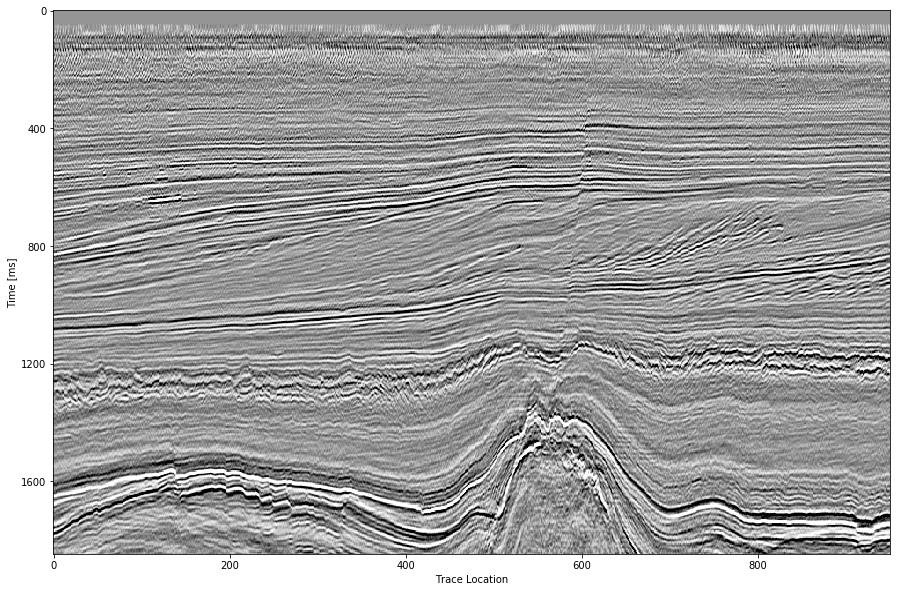

In [11]:
fig2 = plt.figure(figsize=(15.0, 10.0))
vml = np.percentile(labeled_data, 99)
img1 = plt.imshow(labeled_data, cmap="Greys", vmin=-vml, vmax=vml, aspect='auto')
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('labeled_data.png', bbox_inches='tight')
plt.show()

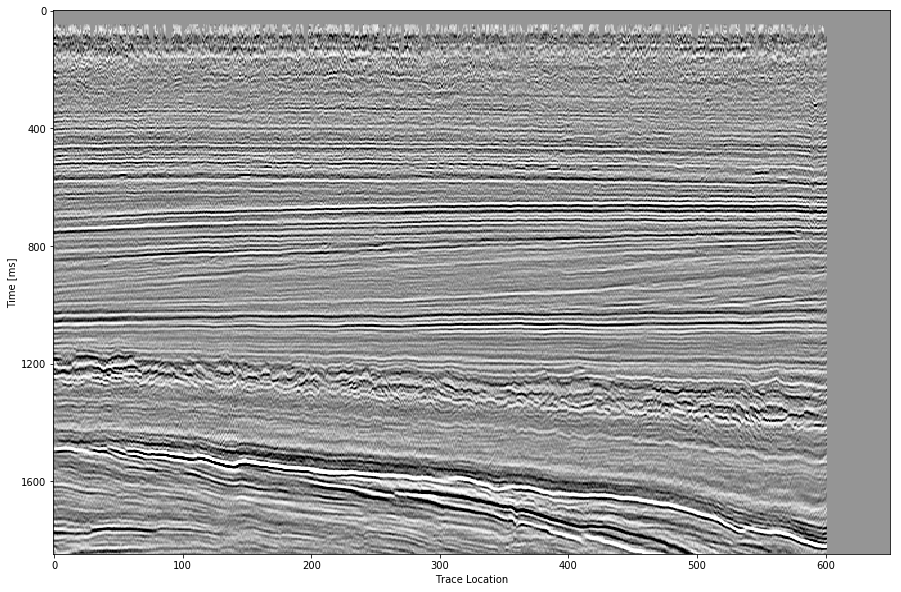

In [12]:
fig2 = plt.figure(figsize=(15.0, 10.0))
vmx = np.percentile(xline_data, 99)
plt.imshow(xline_data, cmap="Greys", vmin=-vmx, vmax=vmx, aspect='auto')
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('xline_data.png', bbox_inches='tight')
plt.show()

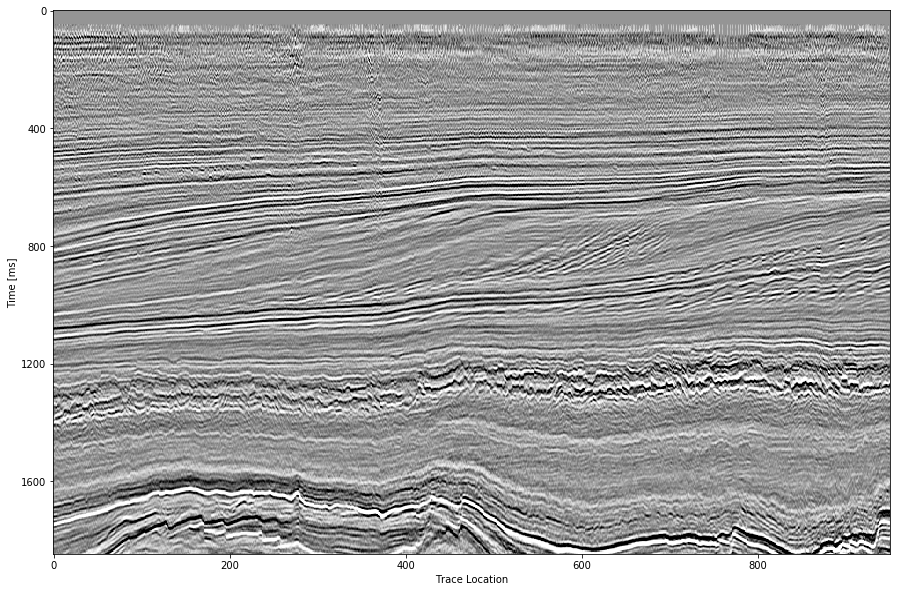

In [13]:
fig2 = plt.figure(figsize=(15.0, 10.0))
vmy = np.percentile(inline_data, 99)
plt.imshow(inline_data, cmap="Greys", vmin=-vmy, vmax=vmy, aspect='auto')
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('inline_data.png', bbox_inches='tight')
plt.show()

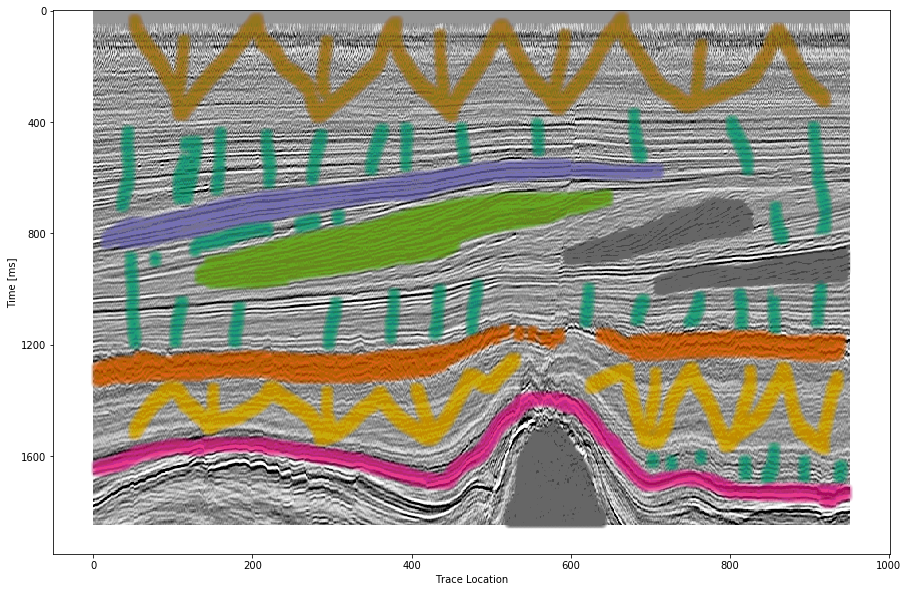

In [14]:
fig2 = plt.figure(figsize=(15.0, 10.0))
img2 = plt.imshow(labeled_data, cmap="Greys", vmin=-vml, vmax=vml, aspect='auto')
img1 = plt.scatter(labels["Xline"],labels[["Time"]],c=labels[["Class"]],cmap='Dark2',alpha=0.03)
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('label.png', bbox_inches='tight')
plt.show()

# Train the Network
Now we perform a test-train split. Then we can validate the results of our experiment.

In [15]:
train_data, test_data, train_samples, test_samples = train_test_split(
    labels, sampler, random_state=42)
print(train_data.shape,test_data.shape)

(119109, 4) (39703, 4)


This is the `keras` data generator that wraps the `patch_extractor2D()`.

In [16]:
class SeismicSequence(keras.utils.Sequence):
    def __init__(self, img, x_set, t_set, y_set, patch_size, batch_size, dimensions):
        self.slice = img
        self.X,self.t = x_set,t_set
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.dimensions = dimensions
        self.label = y_set
    
    def __len__(self):
        return len(self.X) // self.batch_size
    
    def __getitem__(self,idx):
        sampler = np.random.permutation(len(self.X))
        samples = sampler[idx*self.batch_size:(idx+1)*self.batch_size]
        labels = keras.utils.to_categorical(self.label[samples], num_classes=9)
        if self.dimensions == 1:
            return np.expand_dims(np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), axis=4), labels
        else:
            return np.array([patch_extractor2D(self.slice,self.X[x],self.t[x],self.patch_size,self.dimensions) for x in samples]), labels

We define several callbacks for keras. The training should be stopped early, if the validation loss or the categorical cross entropy do not improve within the defined patience. Checkpoints are written to `tmp.h5` for every epoch.

In [17]:
earlystop1 = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')

earlystop2 = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=15,
                              verbose=0, mode='auto')

checkpoint = keras.callbacks.ModelCheckpoint('tmp.h5', 
                                     monitor='val_loss', 
                                     verbose=0, 
                                     save_best_only=False, 
                                     save_weights_only=False, 
                                     mode='auto', 
                                     period=1)

callbacklist = [TQDMNotebookCallback(leave_inner=True, leave_outer=True), earlystop1, earlystop2, checkpoint]

## Waldeland CNN
The model introduced by Waldeland, reproduced from MalenoV. Compared to today's standards this is a relatively shallow CNN. We train the network from scratch.

In [20]:
tf.logging.set_verbosity(tf.logging.ERROR)

model_vanilla = Sequential()
model_vanilla.add(Conv2D(50, (5, 5), padding='same', input_shape=(patch_size,patch_size,1), strides=(4, 4), data_format="channels_last",name = 'conv_layer1'))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(Conv2D(50, (3, 3), strides=(2, 2), padding = 'same',name = 'conv_layer2'))
model_vanilla.add(Dropout(0.5))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(Conv2D(50, (3, 3), strides=(2, 2), padding= 'same',name = 'conv_layer3'))
model_vanilla.add(Dropout(0.4))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(Conv2D(50, (3, 3), strides=(2, 2), padding= 'same',name = 'conv_layer4'))
model_vanilla.add(Dropout(0.2))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(Conv2D(50, (3, 3), strides=(2, 2), padding= 'same',name = 'conv_layer5'))
model_vanilla.add(Flatten())
model_vanilla.add(Dense(50,name = 'dense_layer1'))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(Dense(10,name = 'attribute_layer'))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('relu'))
model_vanilla.add(Dense(num_classes, name = 'pre-softmax_layer'))
model_vanilla.add(BatchNormalization())
model_vanilla.add(Activation('softmax'))

model_vanilla.compile(loss=lossfkt,
                  optimizer=opt,
                  metrics=metrica)

In [ ]:
t0=time.time()

hist_vanilla = model_vanilla.fit_generator(
    SeismicSequence(
        labeled_data,
        train_data["Xline"].values,
        train_data["Time"].values,
        train_data["Class"].values,
        patch_size,
        batch_size,
        1),
    steps_per_epoch=steps,
    validation_data = SeismicSequence(
        labeled_data,
        test_data["Xline"].values,
        test_data["Time"].values,
        test_data["Class"].values,
        patch_size,
        batch_size,
        1),
    validation_steps = len(test_samples)//batch_size,
    epochs = epochs,
    verbose = 0,
    callbacks = callbacklist)

print('--> Training for Waldeland CNN took: '.format(time.time()-t0)) #Thanks to aadm 

HBox(children=(IntProgress(value=0, description='Training', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=450), HTML(value='')))

C:\Users\jdram\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\jdram\AppData\Local\Continuum\anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\jdram\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\jdram\AppData\Local\Continuum\anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=0, description='Epoch 1', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=450), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=450), HTML(value='')))

In [ ]:
model_vanilla.save("vanilla_model.h5")

In [ ]:
vanillascore=model_vanilla.evaluate(np.expand_dims(np.array([patch_extractor2D(labeled_data,labels["Xline"][x],labels["Time"][x],64) for x in test_samples]), axis=4),keras.utils.to_categorical(labels["Class"][test_samples], num_classes=9), verbose=0)
print(acc_assess(vanillascore,lossfkt,metrica))

Looking at the metric on training as well as validation gives a good overview, if we are doing appropriate training or if we are overfitting.

In [ ]:
print(hist_vanilla.history.keys())
plt.plot(hist_vanilla.history['acc'])
plt.plot(hist_vanilla.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(hist_vanilla.history['loss'])
plt.plot(hist_vanilla.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
t_max, y_max = xline_data.shape

half_patch = patch_size//2

predx = np.full_like(xline_data,-1)

for space in tqdm_notebook(range(y_max),desc='Space'):
    for depth in tqdm_notebook(range(t_max),leave=False, desc='Time'):
        predx[depth,space] = np.argmax(model_vanilla.predict(np.expand_dims(np.expand_dims(patch_extractor2D(xline_data,space,depth,patch_size), axis=0), axis=4)))

In [ ]:
np.save('vanilla_predx.npy',predx,allow_pickle=False)

In [ ]:
plt.imshow(predx)

In [ ]:
fig2 = plt.figure(figsize=(15.0, 10.0))
img2 = plt.imshow(xline_data, cmap="Greys", vmin=-vmx, vmax=vmx, aspect='auto')
img1 = plt.imshow(predx, aspect='auto', cmap="Dark2", alpha=0.5)
plt.savefig('pred1_x.png', bbox_inches='tight')
plt.show()

In [ ]:
t_max, y_max = inline_data.shape

half_patch = patch_size//2

predi= np.full_like(inline_data,-1)

for space in tqdm_notebook(range(y_max),desc='Space'):
    for depth in tqdm_notebook(range(t_max),leave=False, desc='Time'):
        predi[depth,space] = np.argmax(model_vanilla.predict(np.expand_dims(np.expand_dims(patch_extractor2D(inline_data,space,depth,patch_size), axis=0), axis=4)))

In [ ]:
np.save('vanilla_predi.npy',predi,allow_pickle=False)

In [ ]:
predi = np.load('vanilla_predi.npy')
plt.imshow(predi)

In [ ]:
np.save('vanilla_predi.npy',predi,allow_pickle=False)
fig2 = plt.figure(figsize=(15.0, 10.0))
img2 = plt.imshow(inline_data, cmap="Greys", vmin=-vmy, vmax=vmy, aspect='auto')
img1 = plt.imshow(predi, aspect='auto', cmap="Dark2", alpha=0.5)
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('pred1_i.png', bbox_inches='tight')
plt.show()

## VGG16 Transfer Learning
We import the VGG16 model trained on the ImageNet dataset. We freeze all layers and cut off the classification part. We can then retrain the classification neurons, to see if the filters generalize to seismic data.

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
K.set_image_dim_ordering('tf')   

In [ ]:
input_tensor = Input(shape=(patch_size,patch_size,3))
base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=None)

for layer in base_model.layers[:8]:
    layer.trainable = False

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(256,name = 'dense_layer1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(.5)(x)
x = Dense(num_classes, name = 'pre-softmax_layer')(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

vgg = Model(input=base_model.input, output=x)

In [ ]:
sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
vgg.compile(loss=lossfkt,
                  optimizer=sgd,
                  metrics=metrica)

In [ ]:
t0 = time.time()

vgg_hist = vgg.fit_generator(
    SeismicSequence(
        labeled_data,
        train_data["Xline"].values,
        train_data["Time"].values,
        train_data["Class"].values,
        patch_size,
        batch_size,
        3),
    steps_per_epoch=steps,
    validation_data = SeismicSequence(
        labeled_data,
        test_data["Xline"].values,
        test_data["Time"].values,
        test_data["Class"].values,
        patch_size,
        batch_size,
        3),
    validation_steps = len(test_data)//batch_size,
    epochs = epochs,
    verbose = 0,
    callbacks = callbacklist)

print('--> Training for VGG transfer took: '.format(time.time()-t0))

In [ ]:
vgg.save('vgg_model.h5')

In [ ]:
vggscore=vgg.evaluate(np.array([patch_extractor2D(labeled_data,labels["Xline"][x],labels["Time"][x],64,3) for x in test_samples]), keras.utils.to_categorical(labels["Class"][test_samples], num_classes=9))
print(acc_assess(vggscore,lossfkt,metrica))

In [ ]:
print(hist_vanilla.history.keys())
plt.plot(vgg_hist.history['acc'])
plt.plot(vgg_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
t_max, y_max = xline_data.shape

half_patch = patch_size//2

vgg_predx = np.full_like(xline_data,-1)

for space in tqdm_notebook(range(y_max),desc='Space'):
    for depth in tqdm_notebook(range(t_max),leave=False, desc='Time'):
        vgg_predx[depth,space] = np.argmax(vgg.predict(np.expand_dims(patch_extractor2D(xline_data,space,depth,patch_size,3), axis=0)))

In [ ]:
np.save('vgg_predx.npy',vgg_predx,allow_pickle=False)

In [ ]:
plt.imshow(vgg_predx)

In [ ]:
vgg_predx=np.load('vgg_predx.npy')
fig2 = plt.figure(figsize=(15.0, 10.0))
img2 = plt.imshow(xline_data, cmap="Greys", vmin=-vmx, vmax=vmx, aspect='auto')
img1 = plt.imshow(vgg_predx, aspect='auto', cmap="Dark2", alpha=0.5)
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('vgg1_x.png', bbox_inches='tight')
plt.show()

In [ ]:
t_max, y_max = inline_data.shape

half_patch = patch_size//2

vgg_predi = np.full_like(inline_data,-1)

for space in tqdm_notebook(range(y_max),desc='Space'):
    for depth in tqdm_notebook(range(t_max),leave=False, desc='Time'):
        vgg_predi[depth,space] = np.argmax(vgg.predict(np.expand_dims(patch_extractor2D(inline_data,space,depth,patch_size,3), axis=0)))

In [ ]:
np.save('vgg_predi.npy',vgg_predi,allow_pickle=False)

In [ ]:
plt.imshow(vgg_predi)

In [ ]:
vgg_predi= np.load('vgg_predi.npy')
fig2 = plt.figure(figsize=(15.0, 10.0))
img2 = plt.imshow(inline_data, cmap="Greys", vmin=-vmy, vmax=vmy, aspect='auto')
img1 = plt.imshow(vgg_predi, aspect='auto', cmap="Dark2", alpha=0.5)
plt.yticks(np.arange(0, 462, 100), np.arange(0, 462*4, 400))
plt.xlabel('Trace Location')
plt.ylabel('Time [ms]')
plt.savefig('vgg1_i.png', bbox_inches='tight')
plt.show()

## ResNet50 Transfer Learning
We import the ResNet50 that was trained on the ImageNet data and freeze all layers, like we did for the VGG16. Then we retrain the classifier to see if the learned filters generalize on seismic data.

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras import backend as K
K.set_image_dim_ordering('tf')   
patch_size=244

In [ ]:
input_tensor = Input(shape=(patch_size,patch_size,3))
res_base = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=None, pooling=None)

for layer in res_base.layers[:45]:
    layer.trainable = False

In [ ]:
q = res_base.output
q = Flatten()(q)
q = BatchNormalization()(q)
q = Activation('relu')(q)
q = Dense(10,name = 'attribute_layer')(q)
q = BatchNormalization()(q)
q = Activation('relu')(q)
q = Dense(num_classes, name = 'pre-softmax_layer')(q)
q = BatchNormalization()(q)
q = Activation('softmax')(q)
resnet = Model(input=res_base.input, output=q)

In [ ]:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
resnet.compile(loss=lossfkt,
                  optimizer=opt,
                  metrics=metrica)

In [ ]:
t0 = time.time()

batch_size=50
res_hist = resnet.fit_generator(
    SeismicSequence(
        labeled_data,
        train_data["Xline"].values,
        train_data["Time"].values,
        train_data["Class"].values,
        patch_size,
        batch_size,
        3),
    steps_per_epoch=steps,
    validation_data = SeismicSequence(
        labeled_data,
        test_data["Xline"].values,
        test_data["Time"].values,
        test_data["Class"].values,
        patch_size,
        batch_size,
        3),
    validation_steps = len(test_data)//batch_size,
    epochs = epochs,
    verbose = 0,
    callbacks = callbacklist)

print('--> Training for ResNet transfer took: '.format(time.time()-t0))

In [ ]:
resnet.save('resnet_model.h5')

In [ ]:
resnetscore=resnet.evaluate(np.array([patch_extractor2D(labeled_data,labels["Xline"][x],labels["Time"][x],patch_size,3) for x in test_samples]), keras.utils.to_categorical(labels["Class"][test_samples], num_classes=9))
print(acc_assess(resnetscore,lossfkt,metrica))

In [ ]:
t_max, y_max = xline_data.shape

half_patch = patch_size//2

resnet_predx = np.full_like(xline_data,-1)

for space in tqdm_notebook(range(y_max),desc='Space'):
    for depth in tqdm_notebook(range(t_max),leave=False, desc='Time'):
        resnet_predx[depth,space] = np.argmax(resnet.predict(np.expand_dims(patch_extractor2D(xline_data,space,depth,patch_size,3), axis=0)))

In [ ]:
np.save('resnet_predx.npy',resnet_predx,allow_pickle=False)

In [ ]:
plt.imshow(resnet_predx)

In [ ]:
fig2 = plt.figure(figsize=(15.0, 10.0))
img2 = plt.imshow(xline_data, cmap="Greys", vmin=-vmx, vmax=vmx, aspect='auto')
img1 = plt.imshow(resnet_predx, aspect='auto', cmap="Dark2", alpha=0.8)
plt.savefig('resnet_x.png', bbox_inches='tight')
plt.show()

In [ ]:
t_max, y_max = inline_data.shape

half_patch = patch_size//2

resnet_predi = np.full_like(inline_data,-1)

for space in tqdm_notebook(range(y_max-400,y_max-300),desc='Space'):
    for depth in tqdm_notebook(range(t_max-400,t_max-300),leave=False, desc='Time'):
        resnet_predi[depth,space] = np.argmax(resnet.predict(np.expand_dims(patch_extractor2D(inline_data,space,depth,patch_size,3), axis=0)))

In [ ]:
np.save('resnet_predi.npy',resnet_predi,allow_pickle=False)

In [ ]:
plt.imshow(resnet_predi)

In [ ]:
fig2 = plt.figure(figsize=(15.0, 10.0))
img2 = plt.imshow(inline_data, cmap="Greys", vmin=-vmy, vmax=vmy, aspect='auto')
img1 = plt.imshow(resnet_predi, aspect='auto', cmap="Dark2", alpha=0.8)
plt.savefig('resnet_i.png', bbox_inches='tight')
plt.show()

In [ ]:
print(res_hist.history.keys())
plt.plot(res_hist.history['acc'])
plt.plot(res_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(res_hist.history['loss'])
plt.plot(res_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plot_model(resnet, to_file='model_resnet.png')
plot_model(resnet, to_file='model_resnet_shapes.png', show_shapes=True)
SVG(model_to_dot(resnet).create(prog='dot', format='svg'))

# Model Summary
We can see the summaries of the layers in the model definitions. Leveraging high-dimensional CNNs that are already trained can be very valuable.

In [ ]:
model_vanilla.summary()

In [ ]:
vgg.summary()

In [ ]:
resnet.summary()